<a href="https://colab.research.google.com/github/attatrol/MADE_ML_Homeworks/blob/master/ML_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import math
from sklearn import linear_model
import random
import scipy

In [6]:
try:
    with open('../../datasets/covid/owid-covid-data.csv', 'r') as iofile:
        data = pd.read_csv('owid-covid-data.csv')
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv -nc
    with open('owid-covid-data.csv', 'r') as iofile:
        data = pd.read_csv('owid-covid-data.csv')

data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

--2020-05-15 08:40:06--  https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2459742 (2.3M) [text/plain]
Saving to: ‘owid-covid-data.csv’

owid-covid-data.csv 100%[===================>]   2.35M  14.1MB/s    in 0.2s    

2020-05-15 08:40:07 (14.1 MB/s) - ‘owid-covid-data.csv’ saved [2459742/2459742]



In [7]:
data.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN


In [8]:
print(datetime.datetime(2020, 3, 3))
# print(data["date"][0].timestamp())

2020-03-03 00:00:00


In [0]:
def filter_data(iso_code = "RUS", from_date = datetime.datetime(2020, 3, 3)):
  return data[(data['iso_code'] == iso_code) & (data['date'] >= from_date)]

In [10]:
rus_data = filter_data()
rus_data.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k
13775,RUS,Russia,2020-03-03,3,1,0,0,0.021,0.007,0.0,0.0,NaN,NaN,NaN,NaN,NaN,145934460.0,8.823,39.6,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05
13776,RUS,Russia,2020-03-04,4,1,0,0,0.027,0.007,0.0,0.0,NaN,NaN,NaN,NaN,NaN,145934460.0,8.823,39.6,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05
13777,RUS,Russia,2020-03-05,4,0,0,0,0.027,0.000,0.0,0.0,46414.0,NaN,0.318,NaN,tests performed,145934460.0,8.823,39.6,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05
13778,RUS,Russia,2020-03-06,4,0,0,0,0.027,0.000,0.0,0.0,51366.0,4952.0,0.352,0.034,tests performed,145934460.0,8.823,39.6,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05
13779,RUS,Russia,2020-03-07,10,6,0,0,0.069,0.041,0.0,0.0,55688.0,4322.0,0.382,0.030,tests performed,145934460.0,8.823,39.6,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05


In [0]:
def print_data(data):
  _, ax = plt.subplots()
  ax.plot(data['date'], data['new_cases'], label = "cases")
  ax.plot(data['date'], data['new_deaths'], label = "deaths")
  ax.plot(data['date'], data['new_tests'], label = "tests")
  ax.set(title='Sequential')
  ax.grid()
  ax.set_yscale("log")
  plt.legend()
  plt.show()

  _, ax = plt.subplots()
  ax.plot(data['date'], data['total_cases'], label = "cases")
  ax.plot(data['date'], data['total_deaths'], label = "deaths")
  ax.plot(data['date'], data['total_tests'], label = "tests")
  ax.set(title='Cumulative')
  ax.grid()
  ax.set_yscale("log")
  plt.legend()
  plt.show()

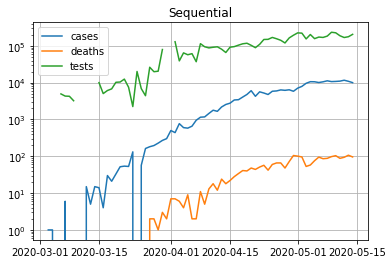

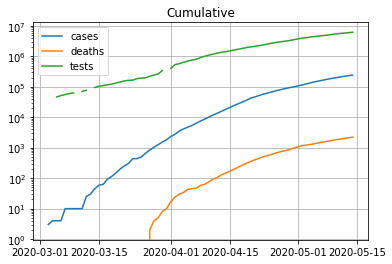

In [12]:
print_data(rus_data)

2.a. Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших:  
 y ~ exp(линейная функция от x), где x — номер текущего дня.

 Решим эту задачу как ln (y) ~ ax + b

In [0]:
def prepare_data(data):
  train = data[:50]
  test = data[50:]
  train_y = train['total_cases'].apply(lambda x: math.log(x)).to_numpy()
  train_x = np.asarray(range(0, train_y.size), dtype = np.int32)
  test_y = test['total_cases'].apply(lambda x: math.log(x)).to_numpy()
  test_x = np.asarray(range(train_y.size, test_y.size + train_y.size), dtype = np.int32)
  return train_x, train_y, test_x, test_y

In [0]:
def train_linear(data):
  train_x, train_y, test_x, test_y = prepare_data(rus_data)
  model = linear_model.LinearRegression(fit_intercept=True).fit(train_x.reshape(-1, 1), train_y)
  train_tredict = model.predict(train_x.reshape(-1, 1))
  test_predict = model.predict(test_x.reshape(-1, 1))

  _, ax = plt.subplots()
  ax.plot(test_x, test_y, label = "test_x")
  ax.plot(train_x, train_y, label = "train_x")
  ax.plot(test_x, test_predict, label = "test_x_predict")
  ax.plot(train_x, train_tredict, label = "train_x_tredict")
  ax.set(title='Sigmoid prediction')
  ax.grid()
  plt.legend()
  plt.show()
  return model

Я решил не выходить из логарифмических координат, и в них все весьма наглядно:

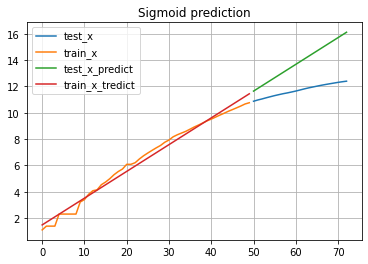

In [15]:
rus_model = train_linear(rus_data)

2.b. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

Значение beta для текущей модели 7.610294030858801


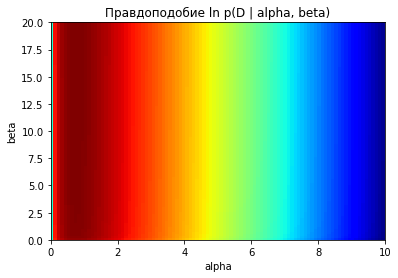

In [16]:
# alpha - коэффициент Ridge регуляризатора
# beta - величина, обратная дисперсии
# логарифм апостериорного распределения гиперпараметров alpha beta
# так как p(a,b) рассматриваем как равномерное, то 
# апостериорное распределение гиперпараметров alpha beta пропорционально правдоподобию alpha и beta при условии точки данных
def ab_posterior(alpha, beta, X, Y, N):
  A = beta * (X.T @ X) + alpha
  m_N = beta * (X.T @ Y) / A
  return math.log(alpha) / 2 + math.log(beta) * N / 2 \
        - beta / 2 * (Y - X * m_N).T @ (Y - X * m_N) \
        - alpha / 2 * m_N * m_N \
        - math.log(abs(A)) / 2 - N / 2 * math.log(2 * 3.14)

# просуммировать ab_posterior по всем точкам данных
# используя текущую модель
def ab_posterior_vectorized(model, prepare_data, point_num = 100):
  probs_alpha = np.arange(0.001, 10.001, 10 / point_num)
  probs_beta = np.arange(0.001, 20.001, 20 / point_num)
  train_x, train_y, test_x, test_y = prepare_data(rus_data)
  test_predict = model.predict(train_x.reshape(-1, 1))
  sq_sum = 0
  for k in range(train_x.size):
    sq_sum = sq_sum + (train_y[k] - test_predict[k]) * (train_y[k] - test_predict[k])
  result = np.zeros(shape=(point_num, point_num))
  for i in range(point_num):
    for j in range(point_num):
      result[i][j] = ab_posterior(probs_alpha[i], probs_beta[j], train_x, train_y, train_x.size)
  return result, train_x.size, (train_x.size - 1) / sq_sum

# построить heatmap
def plot_heatmap(Z, title, point_num):
    plt.xlim((0, 10))
    plt.ylim((0, 20))
    X = np.linspace(0, 10, point_num)
    Y = np.linspace(0, 20, point_num)
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    plt.title(title)
    plt.xlabel("alpha")
    plt.ylabel("beta")
    plt.show()

# построить тепловую карту взаимного распределения apha и beta
def ab_posterior_heatmap(model, prepare_data, point_num = 100):
    Z, total_idx, current_beta = ab_posterior_vectorized(model, prepare_data, point_num)
    print("Значение beta для текущей модели", current_beta)

    plot_heatmap(Z, "Правдоподобие ln p(D | alpha, beta)", point_num)

ab_posterior_heatmap(rus_model, prepare_data)

Максимум alpha расположен близко к нулю, что логично для линейной регрессии с 2 весами. 

Как интерпретировать тот факт, что beta не имеет явно выраженного максимума, совпадающего со значением beta для текущей (оптимальной) модели, я не знаю.

Также есть проблема с независимостью точек данных - в расчете они независимые, а в действительности они составляют числовой ряд.

2.с. Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

[59, 120, 182]


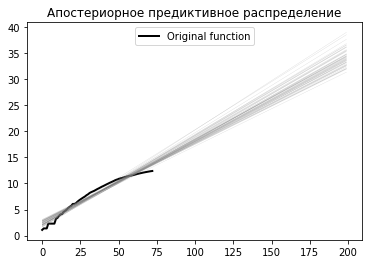

Прогноз заболеваемости
1 мая 136220+-44139
1 июля 2450416488+-3459596250
1 сентября 51759801521505+-184851298799960


In [17]:
def sample(x, y):
  xs = []
  ys = []
  for i in range(x.size):
    if random.random() > 0.8:
      xs.append(x[i])
      ys.append(y[i])
  return np.asarray(xs, dtype = np.int32), np.asarray(ys)

def days_between(d1, d2):
  return abs((d2 - d1).days)

def mean_variance_as_string(sample):
  sample = np.asarray(sample)
  return str(round(math.exp(sample.mean()))) + "+-" + str(round(math.exp(sample.mean() + sample.std()) - math.exp(sample.mean())))

def sample_train_plot(data):
  y = data['total_cases'].apply(lambda x: math.log(x)).to_numpy()
  x = np.asarray(range(0, y.size), dtype = np.int32)
  
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(x, y, linewidth=2, label="Original function", color="black")

  dates = [ \
           days_between(datetime.datetime(2020, 5, 1), datetime.datetime(2020, 3, 3)), \
           days_between(datetime.datetime(2020, 7, 1), datetime.datetime(2020, 3, 3)), \
           days_between(datetime.datetime(2020, 9, 1), datetime.datetime(2020, 3, 3)) \
          ]
  date_samples = [[], [], []]
  print(dates)

  x_predict = np.asarray(range(0, 200), dtype = np.int32)
  res = []
  for _ in range(50):
      xs, ys = sample(x, y)
      model = linear_model.LinearRegression(fit_intercept=True).fit(xs.reshape(-1, 1), ys)
      res.append(model.predict(x_predict.reshape(-1, 1)))
      ax.plot(x_predict, res[-1], linewidth=.1, color="0.5")
      for i in range(len(dates)):
        date_samples[i].append(res[-1][dates[i]])

  ax.legend(loc="upper center")
  plt.title('Апостериорное предиктивное распределение')
  plt.show()

  print("Прогноз заболеваемости")
  print("1 мая " + mean_variance_as_string(date_samples[0]))
  print("1 июля " + mean_variance_as_string(date_samples[1]))
  print("1 сентября " + mean_variance_as_string(date_samples[2]))

sample_train_plot(rus_data)

3. Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:
$ \Phi(x) = \frac{1}{\sqrt{2 \pi}}\int_{-\infty}^{x}{e^{\frac{-t^2}{2}}dt}$  
Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

3.a. Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

По условию имеем
$ y(x) = \int_{0}^{x}{e^{at^2 + bt +c}dt}$  
Вместо кумулятивной функции будем строить регрессию для собственно гауссианы:  
$y'(x) = e^{ax^2 + bx +c}$  
что означает, что вместо поля `total_cases` нужно использовать поле `new_cases` как целевую переменную.
$ln(y'(x)) = ax^2 + bx +c$ 

In [0]:
def prepare_data_sigmoid(data):
  train = data[:60]
  test = data[60:]
  train_y = train['new_cases'].apply(lambda x: 0 if x == 0 else math.log(x)).to_numpy()
  train_x = np.zeros((train_y.size, 3))
  for i in range (train_y.size):
    train_x[i][0] = 1
    train_x[i][1] = i
    train_x[i][2] = i * i
  test_y = test['new_cases'].apply(lambda x: 0 if x == 0 else math.log(x)).to_numpy()
  test_x = np.zeros((test_y.size, 3))
  for i in range (test_y.size):
    test_x[i][0] = 1
    test_x[i][1] = i + train_y.size
    test_x[i][2] = (i + train_y.size) * (i + train_y.size)
  return train_x, train_y, test_x, test_y

In [0]:
def calc_cumulative(x, starting_summand = 0):
  x = np.exp(x)
  x[0] = x[0] + starting_summand
  for i in range(1, x.size):
    x[i] = x[i] + x[i - 1]
  return x

def train_linear_sigmoid(data):
  train_x, train_y, test_x, test_y = prepare_data_sigmoid(data)
  model = linear_model.LinearRegression(fit_intercept=True).fit(train_x, train_y)
  train_predict = model.predict(train_x)

  predict_x = np.zeros((150, 3))
  offset = test_x[0][1]
  for i in range (150):
    predict_x[i][0] = 1
    predict_x[i][1] = i + offset
    predict_x[i][2] = (i + offset) * (i + offset)

  test_predict = model.predict(predict_x)

  train_y = calc_cumulative(train_y)
  test_y = calc_cumulative(test_y, train_y[-1])
  train_predict = calc_cumulative(train_predict)
  test_predict = calc_cumulative(test_predict, train_predict[-1])

  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(test_x.T[1], test_y, label = "test")
  ax.plot(train_x.T[1], train_y, label = "train")
  ax.plot(predict_x.T[1], test_predict, label = "test_predict")
  ax.plot(train_x.T[1], train_predict, label = "train_predict")
  ax.set(title='coords')
  ax.grid()
  plt.legend()
  plt.show()

  return model

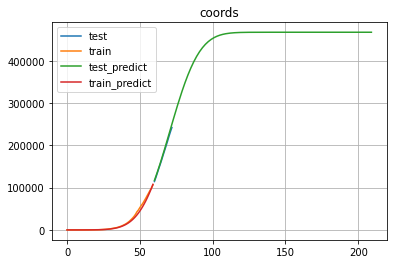

In [63]:
model_sigmoid = train_linear_sigmoid(rus_data)

3.b. Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

Значение beta для текущей модели 5.3870702585341155


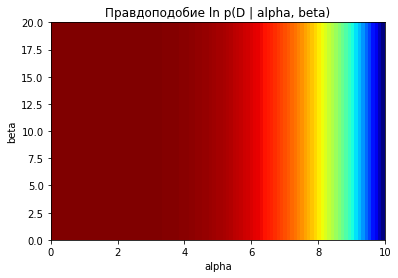

In [21]:
def ab_posterior_sigmoid(alpha, beta, X, Y, N):
  A = beta * (X.T @ X)
  A[0][0] = A[0][0] + alpha
  A[1][1] = A[1][1] + alpha
  m_N = beta * A @ X.T @ Y
  return math.log(alpha) / 2 + math.log(beta) * N / 2 \
        - beta / 2 * (Y - X @ m_N).T @ (Y - X @ m_N) \
        - alpha / 2 * m_N.T @ m_N \
        - math.log(abs(np.linalg.det(A))) / 2 - N / 2 * math.log(2 * 3.14)

# просуммировать ab_posterior по всем точкам данных
# используя текущую модель
def ab_posterior_vectorized_sigmoid(model, prepare_data, point_num = 100):
  probs_alpha = np.arange(0.001, 10.001, 10 / point_num)
  probs_beta = np.arange(0.001, 20.001, 20 / point_num)
  train_x, train_y, test_x, test_y = prepare_data(rus_data)
  train_predict = model.predict(train_x)
  sq_sum = 1
  for k in range(train_y.size):
    sq_sum = sq_sum + (train_y[k] - train_predict[k]) * (train_y[k] - train_predict[k])
  result = np.zeros(shape=(point_num, point_num))
  for i in range(point_num):
    for j in range(point_num):
      result[i][j] = ab_posterior_sigmoid(probs_alpha[i], probs_beta[j], train_x, train_y, train_x.size)
  return result, train_x.size, (train_x.size - 1) / sq_sum

# построить тепловую карту взаимного распределения apha и beta
def ab_posterior_heatmap_sigmoid(model, prepare_data, point_num = 100):
    Z, total_idx, current_beta = ab_posterior_vectorized_sigmoid(model, prepare_data, point_num)
    print("Значение beta для текущей модели", current_beta)
    plot_heatmap(Z, "Правдоподобие ln p(D | alpha, beta)", point_num)

ab_posterior_heatmap_sigmoid(model_sigmoid, prepare_data_sigmoid)

3.c. Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

Вычислим параметры апостериорного распределения

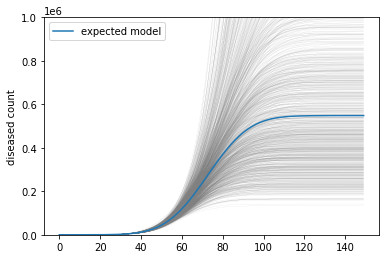

In [22]:
# вычислить апостериорное распределение линейной регрессии
def get_posterior_gauss(model, data, reruns):  
  train_x, train_y, test_x, test_y = prepare_data_sigmoid(data)
  var = np.sum(np.square(model_sigmoid.predict(train_x) - train_y)) / (train_y.size - 1)
  sigma_posterior = np.linalg.inv(np.eye(3) / var + (train_x.T @ train_x) / var)
  mu_posterior = sigma_posterior @ (train_x.T @ train_y) / var
  return scipy.stats.multivariate_normal(mean = mu_posterior, cov = sigma_posterior).rvs(size = reruns)

# семплинг
def sample_sigmoid(model, data, days = 150, reruns = 1000):
  plato_samples = []
  x = np.zeros((days, 3))
  for i in range (days):
    x[i][0] = 1
    x[i][1] = i
    x[i][2] = i * i

  posterior_gauss = get_posterior_gauss(model, data, reruns)

  for sample in posterior_gauss:
    y = np.exp(x @ sample)
    for i in range(1, y.size):
      y[i] = y[i] + y[i - 1]
    plato_samples.append(y[-1])
    plt.plot(x[:, 1], y, linewidth=.05, color="0.5")
  y = np.exp(x @ posterior_gauss.mean(axis=0))
  for i in range(1, y.size):
    y[i] = y[i] + y[i - 1]
  plt.plot(x[:, 1], y, label='expected model')
  plt.ylabel('diseased count')
  plt.ylim((0, 1000000))
  plt.legend()
  plt.show()

  return plato_samples 

max_diseased = sample_sigmoid(sample_sigmoid, rus_data)

In [23]:
print("нижний дециль ", np.percentile(max_diseased, 10))
print("верхний дециль ", np.percentile(max_diseased, 90))

нижний дециль  268571.2542552125
верхний дециль  1714383.3721235173


4. Бонус: проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?

In [0]:
def plot_sigmoids(descs, days = 150):
  x = np.zeros((days, 3))
  for i in range (days):
    x[i][0] = 1
    x[i][1] = i
    x[i][2] = i * i

  for i in range(len(descs)):
    data = filter_data(descs[i][0], descs[i][1])
    train_x, train_y, test_x, test_y = prepare_data_sigmoid(data)
    model = linear_model.LinearRegression(fit_intercept=True).fit(train_x, train_y)
    y = model.predict(x)
    # делим на общее число жителей в стране
    y = calc_cumulative(y) / data['population'].to_numpy()[0]
    plt.plot(x[:, 1], y, label = descs[i][0])
  plt.ylabel('diseased share of population')
  # plt.ylim((0, 4000000))
  plt.legend()
  plt.show()

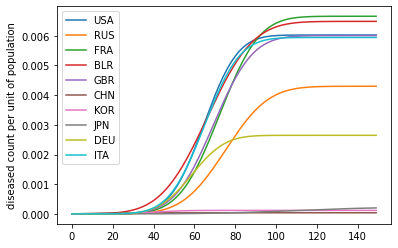

In [131]:
plot_sigmoids([("USA", datetime.datetime(2020, 2, 17)), \
               ("RUS", datetime.datetime(2020, 3, 2)), \
               ("FRA", datetime.datetime(2020, 2, 10)), \
               ("BLR", datetime.datetime(2020, 3, 15)), \
               ("GBR", datetime.datetime(2020, 2, 17)), \
               ("CHN", datetime.datetime(2020, 1, 25)), \
               ("KOR", datetime.datetime(2020, 2, 1)), \
               ("JPN", datetime.datetime(2020, 2, 1)), \
               ("DEU", datetime.datetime(2020, 2, 13)), \
               ("ITA", datetime.datetime(2020, 2, 4)), \
               ])

Визуально разбиение на кластеры:

- страны азии, которые успешно побороли болезнь `CHN`, `JPN`, `KOR`
- западные страны, где должно заболеть 0.5-0.6% населения `USA`, `FRA`, `BLR`, `GBR`, `ITA`
- Германия `DEU` - выброс
- Россия `RUS` - особый путь

Моделирование зависит от начальной точки времени, с которой начинаем считывать данные. Это очень плохо. Проблема в том, что данные не гомоскедастичны?